This notebook explores how to plot the Matlab format files that CReSIS hosts on their own server:

https://data.cresis.ku.edu/data/rds/

In [36]:
import numpy as np
import os
import pyproj

In [28]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

In [109]:
# Ugggh. Turns out that scipy.io can't handle Matlab v7.3 files (which aren't all that new -- supported in R2006b)
import h5py  # `pip3 install h5py`

In [5]:
import scipy  # I had to do `pip3 install scipy`
import scipy.io

In [12]:
os.listdir("/Volumes/RadarData/ANTARCTIC/")

['BAS', 'BEDMAP', 'LDEO', 'KOPRI', 'SOAR', 'AWI', 'CRESIS']

In [14]:
os.listdir(data_dir)

['Data_20131219_01_001.mat',
 'Data_20131219_01_002.mat',
 'Data_20131219_01_003.mat',
 'Data_20131219_01_004.mat',
 'Data_20131219_01_005.mat',
 'Data_20131219_01_006.mat',
 'Data_20131219_01_007.mat',
 'Data_20131219_01_008.mat',
 'Data_20131219_01_009.mat',
 'Data_20131219_01_010.mat',
 'Data_20131219_01_011.mat']

In [13]:
data_dir = "/Volumes/RadarData/ANTARCTIC/CRESIS/2013_Antarctica_Basler/CSARP_mvdr/20131219_01"

In [15]:
datapath = "{}/Data_20131219_01_005.mat".format(data_dir)

In [16]:
mm = scipy.io.loadmat(datapath)

In [20]:
mm['Data']

array([[1.22173769e-16, 2.58436290e-16, 1.23188581e-16, ...,
        1.38917956e-16, 1.59282997e-16, 1.75586687e-16],
       [1.00557998e-16, 1.00270245e-16, 2.51159748e-16, ...,
        2.25423763e-16, 6.33565027e-16, 6.12152352e-16],
       [2.04030120e-16, 1.19586070e-16, 4.42885788e-16, ...,
        2.67013796e-16, 1.82872693e-16, 1.93224097e-16],
       ...,
       [1.05279225e-19, 1.86138592e-19, 4.43255485e-19, ...,
        2.15213978e-19, 2.86819837e-19, 1.68208237e-19],
       [1.79902542e-19, 3.40858176e-19, 1.64273895e-19, ...,
        2.62926363e-19, 1.71614619e-19, 3.74992249e-20],
       [1.82570561e-19, 6.90990107e-20, 9.71745740e-20, ...,
        1.57519487e-19, 1.07210937e-19, 1.04244021e-19]], dtype=float32)

In [19]:
mm.keys()

dict_keys(['__header__', '__version__', '__globals__', 'param_csarp', 'Latitude', 'Longitude', 'Elevation', 'Roll', 'Pitch', 'Heading', 'GPS_time', 'Surface', 'Bottom', 'Data', 'Time', 'Depth', 'param_records', 'param_combine'])

In [110]:
def plot_cresis_matlab_radargram(filepath, xlim=None, highlighted_traces=None):
    """
    Like the netCDF file, there are a lot of non-obvious variables in this one.
    
    Unlike the netCDF file, I needed to take the log of the data for it to show up in a plot.
    
    We can't use scipy.io since it doesn't work for verion 7.3 of the matlab file format.
    Instead, use a HDF reader.
    """
    
    with h5py.File(filepath, 'r') as data:
        radargram = data['Data']    
        print(type(radargram))
        lat = data['Latitude']
        lon = data['Longitude']

        # First dimension is fast time, 2nd dimension is slow time. We want the other way around for plotting.
        radargram = np.log(np.array(radargram).transpose())
        print(radargram.shape, lat.shape)
        ps71 = pyproj.Proj("epsg:3031")
        xx, yy = ps71.transform(lon, lat)
    
        print("Radargram shape: {}, lat shape: {}".format(radargram.shape, lat.shape))

        fig = plt.figure(figsize=(20, 12))
        ax1, ax2 = fig.subplots(1, 2)

        ax1.imshow(radargram, cmap='Greys', aspect='auto')
        ax1.set_title("Radargram")
        
        ax2.plot(xx, yy, 'k.', markersize=2)
        ax2.set_title("Segment track")
        ax2.set_xlabel("Easting (m)")
        ax2.set_ylabel("Northing (m)")
        ax2.axis('equal')
    
        if xlim is not None:
            ax1.set_xlim(xlim)
            ax2.plot(xx[xlim[0]:xlim[1]], yy[xlim[0]:xlim[1]], 'r.', markersize=4)
    
        if highlighted_traces is not None:
            num_samples, _ = radargram.shape
            ax1.vlines(highlighted_traces, 0, radargram.shape[0])
            ax2.plot(xx[highlighted_traces], yy[highlighted_traces], 'co', fillstyle='none', markersize=10)

<class 'h5py._hl.dataset.Dataset'>
(2114, 3335) (3335, 1)
Radargram shape: (2114, 3335), lat shape: (3335, 1)


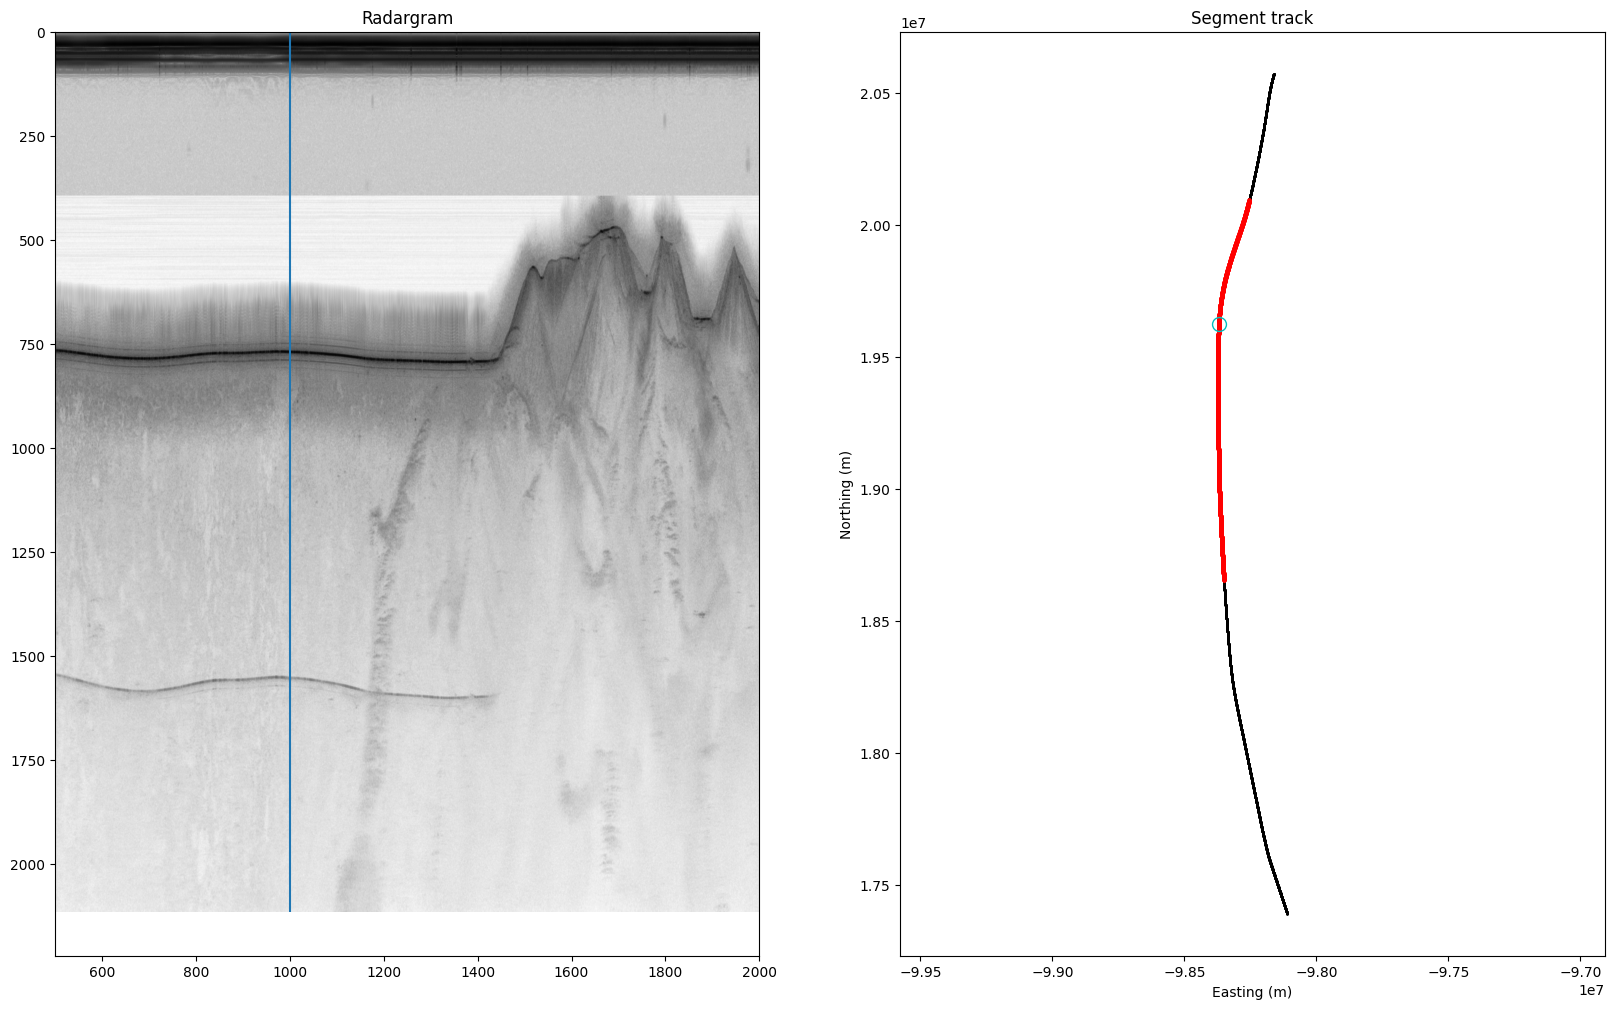

In [111]:
plot_cresis_matlab_radargram(datapath, (500, 2000), 1000)

In [106]:
import pickle

In [107]:
# Now, let's check that the fields exist in each file:
cresis_datafiles = pickle.load(open("cresis_datafiles.pkl", 'rb'))

In [108]:
#  cresis_datafiles[pole][campaign][product][segment] = {file: "{}/{}".format(segment_url, file) for file in files}
for pole, campaigns in cresis_datafiles.items():
    print(pole)
    for campaign, products in campaigns.items():
        print(campaign)
        for product, segments in products.items():
            for segment, frames in segments.items():
                for frame in frames:
                    datapath = "/Volumes/RadarData/{}/CRESIS/{}/{}/{}/{}".format(pole, campaign, product, segment, frame)
                    if os.path.isfile(datapath):
                        with h5py.File('/Volumes/RadarData/ARCTIC/CRESIS/2016_Greenland_G1XB/CSARP_standard/20160413_01/Data_20160413_01_001.mat', 'r') as data:

                            try:
                                radargram = data['Data']    
                                lat = data['Latitude']
                                lon = data['Longitude']
                                if lat.shape[0] == radargram.shape[0]:
                                    print("Success for frame {}".format(frame))
                                else:
                                    print("ERROR: Radargram for {} has shape {}, but lat's shape is {}".format(datapath, radargram.shape, lat.shape))
                            except Exception as ex:
                                print("ERROR: Matlab file does not have required variables.", ex)
                            
                        break # assume that if one file in a segment fails/works, they all will
                    else:
                        print("Could not find file! {}".format(datapath))
                break # assume we only need to test one flight in a campaign
                            
                        
                            

    

ANTARCTIC
2002_Antarctica_P3chile
Success for frame Data_20021126_01_001.mat
2004_Antarctica_P3chile
Success for frame Data_20041118_01_001.mat
2005_Antarctica_GPRWAIS
Success for frame Data_20060103_01_001.mat
2009_Antarctica_DC8
Success for frame Data_20091016_01_001.mat
2009_Antarctica_TO
Success for frame Data_20091224_01_001.mat
2009_Antarctica_TO_Gambit
Success for frame Data_20081223_01_001.mat
2010_Antarctica_DC8
Success for frame Data_20101026_02_022.mat
2011_Antarctica_DC8
Success for frame Data_20111012_41_001.mat
2011_Antarctica_TO
Success for frame Data_20111129_06_001.mat
2012_Antarctica_DC8
Success for frame Data_20121012_03_001.mat
2013_Antarctica_Basler
Success for frame Data_20131219_01_001.mat
2013_Antarctica_P3
Success for frame Data_20131119_01_001.mat
2014_Antarctica_DC8
Success for frame Data_20141018_04_001.mat
2016_Antarctica_DC8
Success for frame Data_20161014_03_001.mat
2017_Antarctica_Basler
Success for frame Data_20171129_01_001.mat
2017_Antarctica_P3
Succe

In [78]:
ff = h5py.File('/Volumes/RadarData/ARCTIC/CRESIS/2016_Greenland_G1XB/CSARP_standard/20160413_01/Data_20160413_01_001.mat', 'r')

In [79]:
ff.keys()

<KeysViewHDF5 ['#refs#', 'Bottom', 'Data', 'Elevation', 'GPS_time', 'Heading', 'Latitude', 'Longitude', 'Pitch', 'Roll', 'Surface', 'Time', 'param_combine', 'param_csarp', 'param_records']>

In [80]:
radargram = ff['Data']

In [81]:
radargram.shape

(404, 233)

In [83]:
ff['Longitude'].shape

(404, 1)